### From Gelman & Hill: Data Analysis Using Regression and Multilevel Models (Ch. 7)

The idea here is that, before going full Bayesian, we can get a sense for how Bayesian Posterior Predictions work by creating a normal linear regression model and then approximating a Bayesian Posterior Predictive Distribution by sampling from our predictions.

In [1]:
## import libraries

from sklearn import datasets
import pandas as pd
import numpy as np
import statsmodels.api as smf
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
## iris data set
iris = datasets.load_iris()

## convert to pandas sata frame
data = iris['data']
target = iris['target']

iris_df = pd.DataFrame(data)
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
iris_df.head(3)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


### Build a linear regression (traditional ordinary least squares)

In [3]:
## Set up our X and y variables
X = iris_df['petal_length']
y = iris_df['petal_width']

In [4]:
# NOTE: statsmodels does not automatically add an intercept, so you need to do that manually

X = smf.add_constant(X)

# Build regression model
# NOTE: the X and y variables are reversed in the function compared to sklearn

fit_lm = smf.OLS(y, X).fit()

# Get an R-like output of the model

fit_lm.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            petal_width   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1882.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           4.68e-86
Time:                        18:49:58   Log-Likelihood:                 24.796
No. Observations:                 150   AIC:                            -45.59
Df Residuals:                     148   BIC:                            -39.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.3631      0.040     -9.131      0.000      -0.442      -0.285
petal_length     0.4158      0.010     43.387      0.000       0.397       0.435
==============================================================================
Omnibus:                        5.765   Durbin-Watson:                   1.455
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.555
Skew:                           0.359   Prob(JB):                       0.0622
Kurtosis:                       3.611   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### First simulate a distirbution around the Slope Coefficient

* The slope coefficient for `petal_length` is 0.4158 with a standard error of 0.01.
* We can use this information to build a posterior simulation of the slope coefficient.

In [5]:
## get summary stats
mu_slope = 0.4158
se_slope = 0.01

## create simulation
n_samples = 10000
coef_sim = np.random.normal(loc = mu_slope, scale = se_slope, size = n_samples)

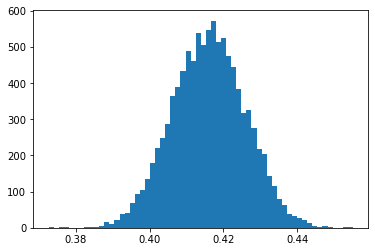

In [6]:
## plot simulated distribution

plt.hist(coef_sim, bins = 60)
plt.show()

In [58]:
## get summary stats from our simulation
summary_stats = {
    'Mean': coef_sim.mean(),
    'Low90': np.quantile(coef_sim, 0.05),
    'High90': np.quantile(coef_sim, 0.95)
}

summary_stats

{'Mean': 0.4162082668715149,
 'Low90': 0.3669853338376307,
 'High90': 0.46503374384504764}

### Make a prediction on a new obseration and build a posterior predictive simulation

In [69]:
new_dat = np.array([[1, 1.7]])    # add a 1 upfront to indicate the model intercept
new_dat

array([[1. , 1.7]])

In [70]:
prediction = fit_lm.get_prediction(new_dat)
prediction

In [71]:
prediction.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.343709,0.025945,0.292438,0.394979,-0.067538,0.754956


* We want to create a posterior predictive distribution for this individual new observation (not a population average). Thus, we will use the prediction interval, which is called `obs_ci_lower` and `obs_ci_upper` here.

In [72]:
mu_pred = 0.343709
se_pred = 0.754956 - 0.343709     # subtract the upper prediction interval from the mean to get the variability
n_sims = 10000

pred_obs = np.random.normal(loc = mu_pred, scale = se_pred, size = n_sims)

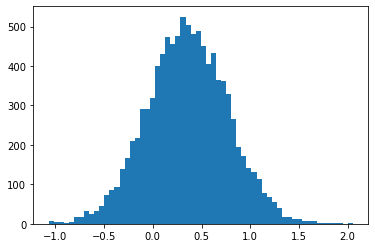

In [73]:
plt.hist(pred_obs, bins = 60)
plt.show()

In [74]:
## get summary stats from our simulation
summary_stats = {
    'Mean': pred_obs.mean(),
    'Low90': np.quantile(pred_obs, 0.05),
    'High90': np.quantile(pred_obs, 0.95)
}

summary_stats

{'Mean': 0.35544530885021625,
 'Low90': -0.3178877847515099,
 'High90': 1.044449387252352}

### How was the prediction interval calculated?

* It may help to see how a prediciton interval (and confidence interval) are calculated by hand, so that we can have an apprecication for how they work and how we can use them in other scenarios.

**First, to calculate either the the confidence interval or prediction interval there are a few pieces of information that we need:**

1) The model degrees of freedom, which is called `DF Residual` in our model output above.


2) The number of observations in our data.


3) The t-critical value that represents how certain we want to be (here we will build a 95% Interval).


4) The average and standard deviation of the independent variable (`petal_length`) in our data.

5) The residual standard error for the model.

In [91]:
model_df = 148    # this makes sense given that we have 2 parameters in our model (slope & intercept) so degrees of freedom is 150 - 2
n_obs = len(iris_df)
petal_length_mean = iris_df['petal_length'].mean()
petal_length_sd = iris_df['petal_length'].std()

Next we need the `t-critical value`. For this you need:

1) Model degrees of freedom (which we have above)

2) The alpha level corresponding to the percent of confidence you want for your interval

We are interested in 95% confidence, meaning that the interval should encompass 95% of the distribution. Thus, we are left with 5% (1 - 0.95) of the data in the tails. Because this is a two sided test we end up shaving 2.5% (0.05 / 2) off both the right and left sides of the distribution. Thus, we end up with `0.025` in the left tail and `0.975` in the right tail. Let's use that upper tail percentage to get our t-critical value.

**NOTE: General rule of thumb, if you have a good amount of data is that the critical value for 90% is 1.65, 95% is 1.96 (often times people round this up to 2, to be safe), and for 99% is 2.58** 


In [94]:
t_crit = stats.t(df = model_df).ppf(0.975)
t_crit

1.9761224936033632

Now that we have the t-critical value, the final piece is the model's residual standard error. This is simply calculated as:

$rse = sqrt((sum.of.squared.residuals)^2 / model.df)$

In [110]:
predicted_values = fit_lm.predict()
squared_resid = (y - predicted_values)**2
sum_squared_resid = sum_squared_resid.sum()

rse = np.sqrt(sum_squared_resid / model_df)
rse

0.20648434891360867

**Prediction Interval Calculation**

Now that we have the ingredients, we calculate the prediction interval:

$pred.interval95 = t.crit * rse * sqrt(1 + 1 / N.obs + ((petal.length.obs - petal.length.avg)^2) / ((N - 1) * petal.length.sd^2))$

In [130]:
pred95 = t_crit * rse * np.sqrt(1 + 1/n_obs + ((new_dat[0][1] - petal_length_mean)**2) / ((n_obs - 1) * petal_length_sd**2))
pred95

0.4112468496052437

In [132]:
## Confirm that we got the same result as the function above from statsmodels.api gave us.
se_pred

0.411247

**It worked!**

### How is a Confidence Interval Created?

The calculation for our confidence interval is a similar to that of the prediction interval but we are missing one of the terms (we are estimating at a population level here, so we don't have to bake in additional uncertainty). The good news is that we already have the ingredients. The confidence level can be calculated as such:

$CL95 = t.crit * rse * sqrt(1/N.obs + ((petal.length.obs - petal.length.avg)^2) / ((N.obs - 1) * petal.length.sd^2))$

In [133]:
cl95 = t_crit * rse * np.sqrt(1/n_obs + ((new_dat[0][1] - petal_length_mean)**2) / ((n_obs - 1) * petal_length_sd**2))
cl95

0.05127048666266827

In [134]:
## Subtract the mean prediction for the new observation from the upper confidence interval, from the above
# table to get the Confidence Level from statsmodels.api

0.394979 - 0.343709

0.05127000000000004

**Our math checks out and we get the same result! Notice that the Confidence Interval is smaller than the Prediciton Interval because, again, we are making population inference with the Confidence Interval and thus we don't have as much uncertainty as we would if we were estimating for a single observation.**